# Modeling

## LSTM

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from datetime import datetime
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [2]:
df_phone_accel_orig = pd.read_csv(".\\processed\\phone\\accel\\data.csv")
df_watch_accel_orig = pd.read_csv(".\\processed\\watch\\accel\\data.csv")

df_phone_gyro_orig = pd.read_csv(".\\processed\\phone\\gyro\\data.csv")
df_watch_gyro_orig = pd.read_csv(".\\processed\\watch\\gyro\\data.csv")

In [3]:
#Function for model training

def model_train(X_train,Y_train,model_name='vanilla'):
    if(model_name=='vanilla'):
        model = Sequential()
        model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')

    elif(model_name=='stacked'):
        model = Sequential()
        model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(100, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

    elif(model_name=='bi'):
        model = Sequential()
        model.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

    history = model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1, shuffle=False)

    model.summary()

    return model

In [4]:
#Function for creating the dataset with specified look back

def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [5]:
#Function for spliting the data into train and test

def create_split(activity2check,ID2check,device,meter):
    if(device=='phone'):
        if(meter=='acc'):
            dataset = df_phone_accel_orig[df_phone_accel_orig['activity']==activity2check] # Slecting the activity
            dataset = dataset[dataset['ID']==ID2check] #Selecting the ID
        elif(meter=='gyro'):
            dataset = df_phone_gyro_orig[df_phone_gyro_orig['activity']==activity2check]
            dataset = dataset[dataset['ID']==ID2check]
    
    if(device=='watch'):
        if(meter=='acc'):
            dataset = df_watch_accel_orig[df_watch_accel_orig['activity']==activity2check] # Slecting the activity
            dataset = dataset[dataset['ID']==ID2check] #Selecting the ID
        elif(meter=='gyro'):
            dataset = df_watch_gyro_orig[df_watch_gyro_orig['activity']==activity2check]
            dataset = dataset[dataset['ID']==ID2check]

            
    dataset['avg'] = np.sqrt(dataset['x']**2 + dataset['y']**2+dataset['z']**2) #Avg accln
    dataset['timestamp']=range(0,len(dataset))
    dataset['timestamp']=pd.to_datetime(dataset['timestamp'], unit='s')
    dataset = dataset.set_index('timestamp')
    dataset=dataset.drop(columns=['ID', 'activity','meter','device','x','y','z'])
    values = dataset.values
    dataset = dataset.avg.values 
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    train_size = int(len(dataset) * 0.66)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    return dataset,train,test,scaler

In [6]:
#Function for plotting the graph

def plot_graph(dataset,train_predict,test_predict,look_back):
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict

    print(len(trainPredictPlot))
    plt.figure(figsize=(20,6))
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

## Accln modeling

In [7]:
dataset,train,test,scaler=create_split('P',1600,'phone','acc')

In [8]:
look_back = 200
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [9]:
model=model_train(X_train,Y_train,'stacked')

W0829 15:42:33.479299 33568 module_wrapper.py:139] From C:\Users\Rohan Pandey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 15:42:33.483288 33568 module_wrapper.py:139] From C:\Users\Rohan Pandey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 15:42:33.487278 33568 module_wrapper.py:139] From C:\Users\Rohan Pandey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 15:42:33.840178 33568 module_wrapper.py:139] From C:\Users\Rohan Pandey\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0829 15:42:34.021693 33568 deprecation.py:323] From C:\Users\Rohan Pand

Epoch 1/100


W0829 15:42:35.560043 33568 module_wrapper.py:139] From C:\Users\Rohan Pandey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0829 15:42:35.562040 33568 module_wrapper.py:139] From C:\Users\Rohan Pandey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W0829 15:42:35.704656 33568 module_wrapper.py:139] From C:\Users\Rohan Pandey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



2157/2157 [==============================] - 2s 839us/step - loss: 0.0228
Epoch 2/100
2157/2157 [==============================] - 0s 111us/step - loss: 0.0055
Epoch 3/100
2157/2157 [==============================] - 0s 111us/step - loss: 0.0052
Epoch 4/100
2157/2157 [==============================] - 0s 111us/step - loss: 0.0052
Epoch 5/100
2157/2157 [==============================] - 0s 112us/step - loss: 0.0051
Epoch 6/100
2157/2157 [==============================] - 0s 112us/step - loss: 0.0051
Epoch 7/100
2157/2157 [==============================] - 0s 111us/step - loss: 0.0051
Epoch 8/100
2157/2157 [==============================] - 0s 141us/step - loss: 0.0050
Epoch 9/100
2157/2157 [==============================] - 0s 125us/step - loss: 0.0050
Epoch 10/100
2157/2157 [==============================] - 0s 113us/step - loss: 0.0050
Epoch 11/100
2157/2157 [==============================] - 0s 111us/step - loss: 0.0049
Epoch 12/100
2157/2157 [==============================] - 0s 117

In [10]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.665475984451492
Train Root Mean Squared Error: 0.9089990654844043
Test Mean Absolute Error: 0.7131063236276766
Test Root Mean Squared Error: 0.9847979708755802


3574


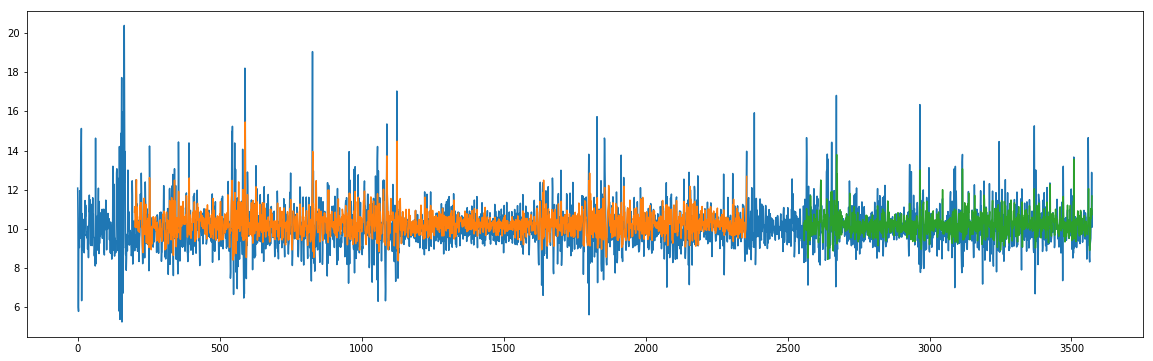

In [11]:
plot_graph(dataset,train_predict,test_predict,look_back)

## Gyroscope Modeling

In [12]:
dataset,train,test,scaler=create_split('P',1600,'phone','gyro')

In [13]:
look_back = 200
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [14]:
model_train(X_train,Y_train,'stacked')

Epoch 1/100
2155/2155 [==============================] - 2s 728us/step - loss: 0.0124
Epoch 2/100
2155/2155 [==============================] - 0s 121us/step - loss: 0.0079
Epoch 3/100
2155/2155 [==============================] - 0s 114us/step - loss: 0.0072
Epoch 4/100
2155/2155 [==============================] - 0s 116us/step - loss: 0.0064
Epoch 5/100
2155/2155 [==============================] - 0s 127us/step - loss: 0.0058
Epoch 6/100
2155/2155 [==============================] - 0s 165us/step - loss: 0.0054
Epoch 7/100
2155/2155 [==============================] - 0s 147us/step - loss: 0.0050
Epoch 8/100
2155/2155 [==============================] - 0s 140us/step - loss: 0.0048
Epoch 9/100
2155/2155 [==============================] - 0s 122us/step - loss: 0.0045
Epoch 10/100
2155/2155 [==============================] - 0s 113us/step - loss: 0.0043
Epoch 11/100
2155/2155 [==============================] - 0s 131us/step - loss: 0.0041
Epoch 12/100
2155/2155 [============================

In [15]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.9645156523532348
Train Root Mean Squared Error: 1.0489274504332626
Test Mean Absolute Error: 0.9602831391176367
Test Root Mean Squared Error: 1.0328086966923398


3570


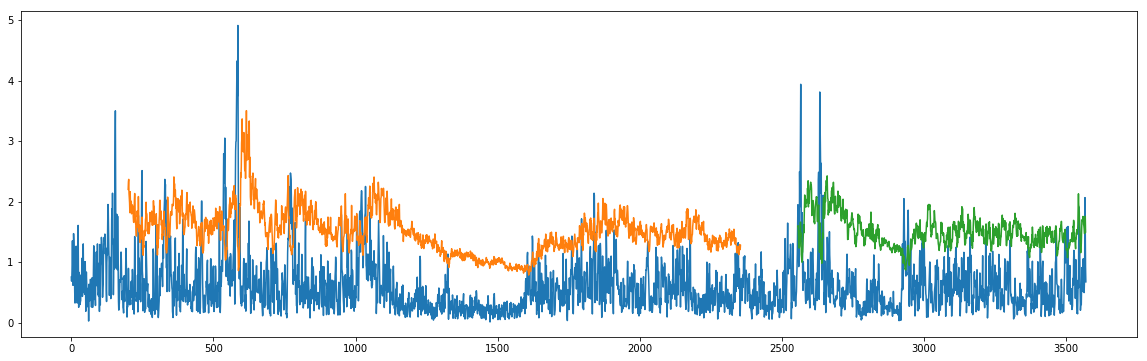

In [16]:
plot_graph(dataset,train_predict,test_predict,look_back)